In [556]:
import pickle

# Build a dict of only-existing objects (safe)
to_save = {}
candidates = [
    'smote_grid_best', 'l1_selected', 'selected_feature_names',
    'scaler', 'encoder', 'metrics_summary'
]

for n in candidates:
    if n in globals():
        to_save[n] = globals()[n]

print("Will save:", list(to_save.keys()))

# Save to a single file
with open("final_model_anshul.pkl", "wb") as f:
    pickle.dump(to_save, f)

print("final_model_anshul.pkl")


Will save: ['selected_feature_names', 'scaler', 'metrics_summary']
final_model_anshul.pkl


In [557]:
import pickle

with open("final_model_anshul.pkl", "rb") as f:
    artifacts = pickle.load(f)

In [558]:
# step 0 (setting up env)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [559]:
# sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix,
                             roc_curve, precision_recall_curve)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel

In [560]:
# imblearn pipeline & samplers
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [561]:
DATA_PATH = "/content/car_insurance_fraud_dataset.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.20

In [562]:
df = pd.read_csv(DATA_PATH)
df.columns.tolist()

['policy_id',
 'policy_state',
 'policy_deductible',
 'policy_annual_premium',
 'insured_age',
 'insured_sex',
 'insured_education_level',
 'insured_occupation',
 'insured_hobbies',
 'incident_date',
 'incident_type',
 'collision_type',
 'incident_severity',
 'authorities_contacted',
 'incident_state',
 'incident_city',
 'incident_hour_of_the_day',
 'number_of_vehicles_involved',
 'bodily_injuries',
 'witnesses',
 'police_report_available',
 'claim_amount',
 'total_claim_amount',
 'fraud_reported']

In [563]:
df.shape

(30000, 24)

In [564]:
df.head()

,policy_id,policy_state,policy_deductible,policy_annual_premium,insured_age,insured_sex,insured_education_level,insured_occupation,insured_hobbies,incident_date,...,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,police_report_available,claim_amount,total_claim_amount,fraud_reported
0,POL100000,GA,400,1430.78,74,OTHER,High School,Manager,reading,2024-06-13,...,MI,Charlesville,6,1,4,0,Yes,8161.36,11677.60,Y
1,POL100001,PA,300,854.49,74,MALE,College,Lawyer,chess,2025-03-23,...,OH,Joshuaberg,0,3,4,5,No,18561.79,18027.81,N
2,POL100002,MI,400,1247.28,28,OTHER,PhD,Doctor,reading,2025-01-26,...,MI,Reynoldsfurt,14,4,4,1,No,10734.61,10375.59,N
3,POL100003,CA,600,622.42,37,MALE,PhD,Teacher,yachting,2024-06-03,...,NC,Josephchester,22,3,3,5,No,13188.92,14204.34,N
4,POL100004,MI,700,1458.17,31,OTHER,PhD,Sales,reading,2024-05-21,...,NY,Caitlinfort,18,4,2,4,No,21864.69,24038.84,N


In [565]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   policy_id                    30000 non-null  object 
 1   policy_state                 30000 non-null  object 
 2   policy_deductible            30000 non-null  int64  
 3   policy_annual_premium        30000 non-null  float64
 4   insured_age                  30000 non-null  int64  
 5   insured_sex                  30000 non-null  object 
 6   insured_education_level      30000 non-null  object 
 7   insured_occupation           30000 non-null  object 
 8   insured_hobbies              30000 non-null  object 
 9   incident_date                30000 non-null  object 
 10  incident_type                30000 non-null  object 
 11  collision_type               30000 non-null  object 
 12  incident_severity            30000 non-null  object 
 13  authorities_cont

In [566]:
df.describe()

,policy_deductible,policy_annual_premium,insured_age,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,claim_amount,total_claim_amount
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,562.783333,1051.255214,46.500133,11.505000,2.508933,1.997600,2.504667,10823.078981,12757.736600
std,250.413012,260.357163,16.707778,6.896155,1.116555,1.411829,1.707691,6629.690781,7028.920069
min,200.000000,600.020000,18.000000,0.000000,1.000000,0.000000,0.000000,266.740000,502.180000
25%,300.000000,826.320000,32.000000,6.000000,2.000000,1.000000,1.000000,5350.947500,6685.507500
50%,600.000000,1051.155000,46.000000,12.000000,3.000000,2.000000,2.000000,10204.170000,12740.430000
75%,800.000000,1277.902500,61.000000,17.000000,4.000000,3.000000,4.000000,15381.867500,18809.910000
max,1000.000000,1499.980000,75.000000,23.000000,4.000000,4.000000,5.000000,29719.870000,24999.720000


In [567]:
df.isnull().sum()

,0
policy_id,0
policy_state,0
policy_deductible,0
policy_annual_premium,0
insured_age,0
insured_sex,0
insured_education_level,0
insured_occupation,0
insured_hobbies,0
incident_date,0


In [568]:
duplicate_count = df.duplicated().sum()
print("Duplicate rows: duplicate_count")
df.duplicated().sum()

Duplicate rows: duplicate_count


np.int64(0)

In [569]:
df.nunique()

,0
policy_id,30000
policy_state,10
policy_deductible,8
policy_annual_premium,25469
insured_age,58
insured_sex,3
insured_education_level,4
insured_occupation,8
insured_hobbies,7
incident_date,731


In [570]:
# set target column
target_col = 'fraud_reported'

# map to binary
def map_to_binary(v):
    s = str(v).strip().upper()
    if s in ("Y","YES","TRUE","1"):
        return 1
    elif s in ("N","NO","FALSE","0"):
        return 0
    else:
        try:
            val = float(v)
            return 1 if val == 1 else 0
        except Exception:
            return 0

y_raw = df[target_col].map(map_to_binary)
print("Target value counts (mapped):")
print(y_raw.value_counts())

Target value counts (mapped):
fraud_reported
0    26560
1     3440
Name: count, dtype: int64



EDA: missing values (top 20)
authorities_contacted          7564
policy_id                         0
policy_deductible                 0
policy_state                      0
insured_age                       0
insured_sex                       0
insured_education_level           0
policy_annual_premium             0
insured_occupation                0
insured_hobbies                   0
incident_type                     0
incident_date                     0
collision_type                    0
incident_severity                 0
incident_state                    0
incident_city                     0
incident_hour_of_the_day          0
number_of_vehicles_involved       0
bodily_injuries                   0
witnesses                         0
dtype: int64


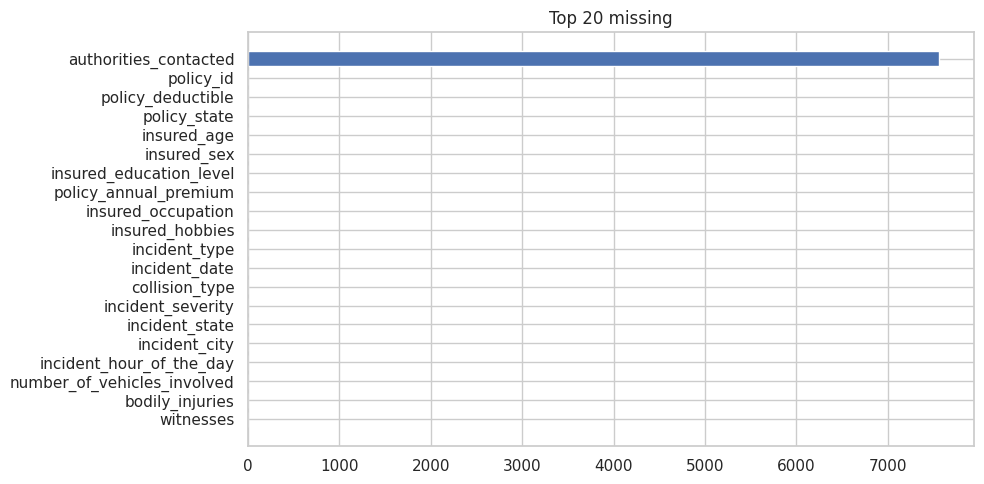


Numeric columns sample: ['policy_deductible', 'policy_annual_premium', 'insured_age', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'claim_amount', 'total_claim_amount']


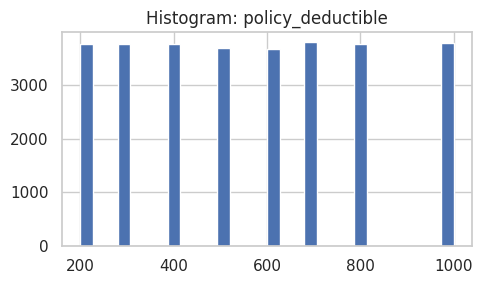

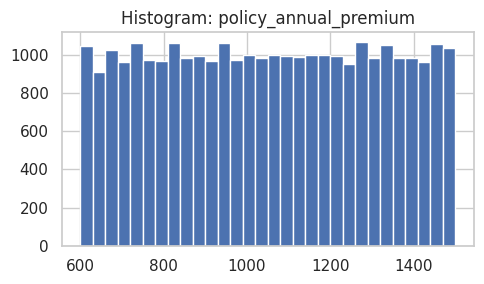

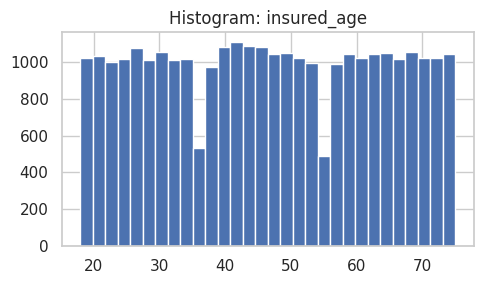

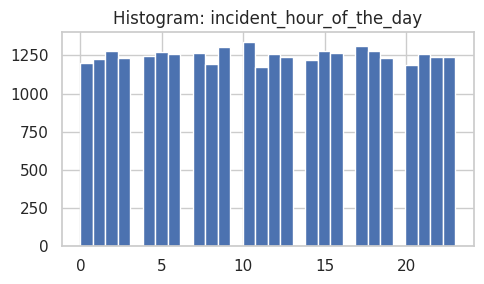

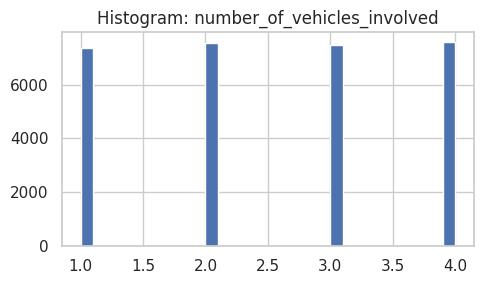

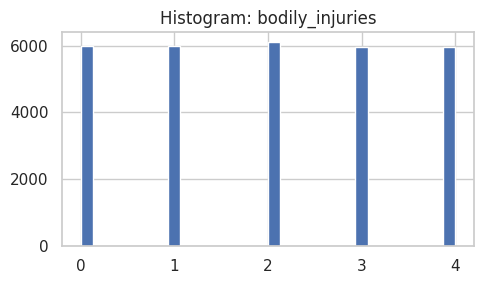

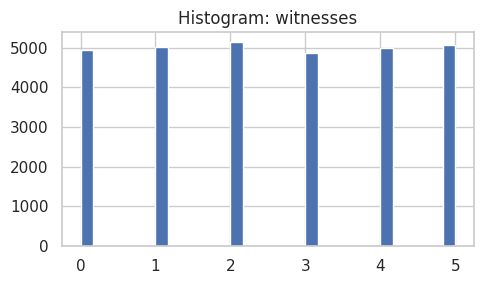

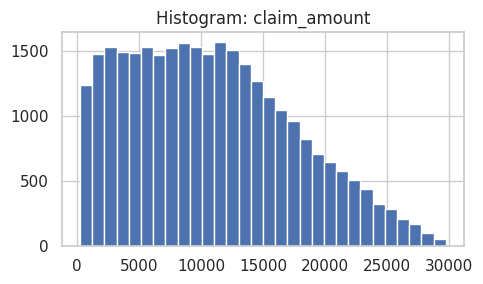


Categorical columns sample: ['policy_id', 'policy_state', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'incident_date', 'incident_type', 'collision_type', 'incident_severity']


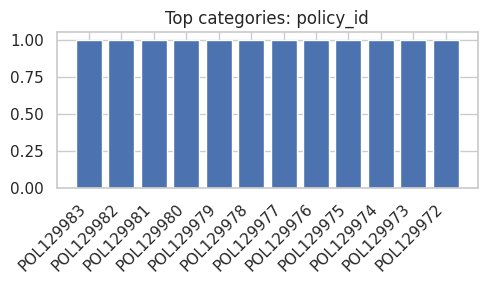

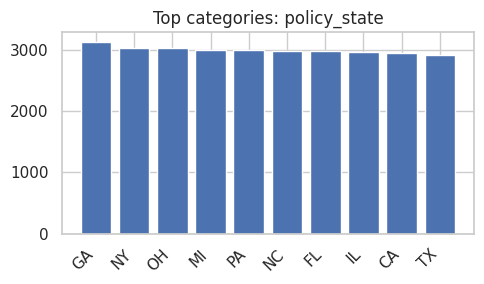

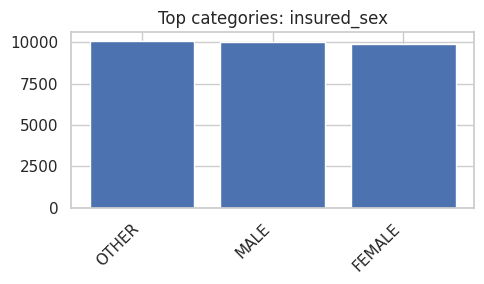

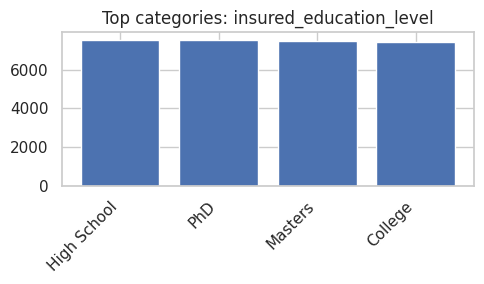

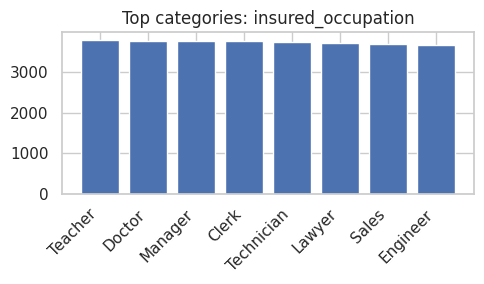

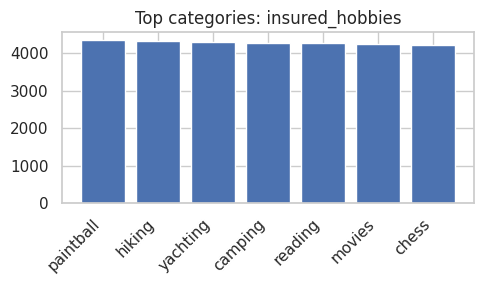

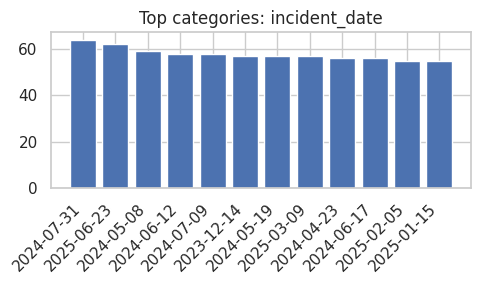

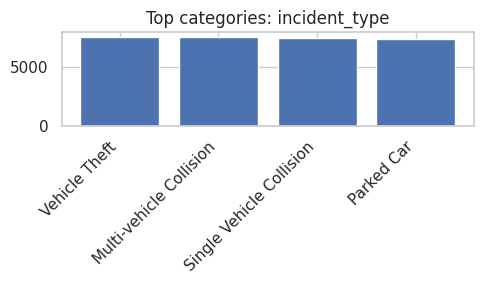

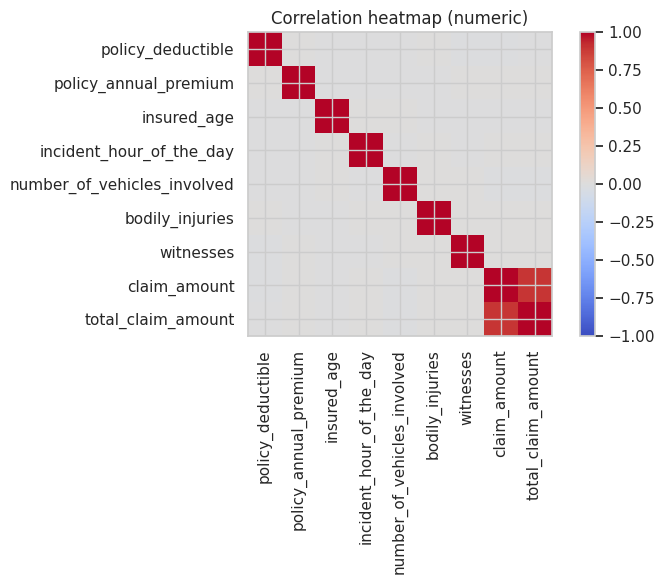


Correlation Heatmap with Target:


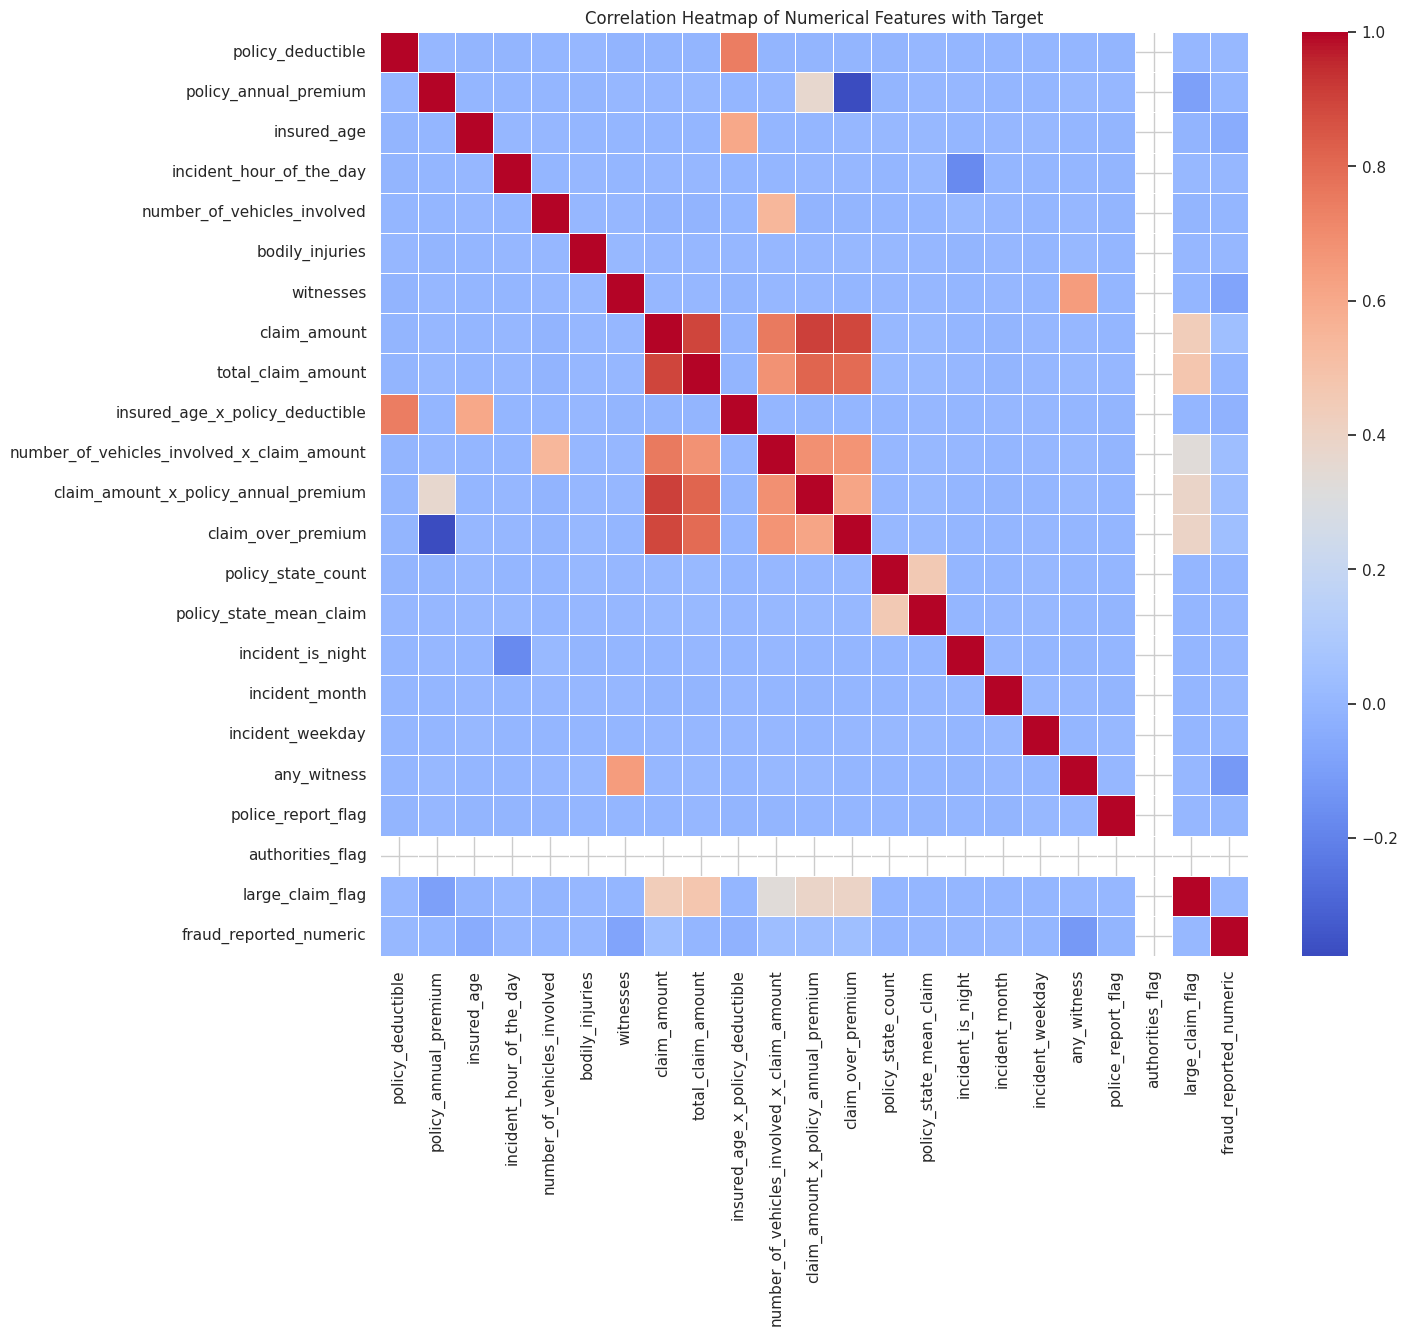

In [571]:
# EDA visuals: missing, numeric histograms, categorical bars, correlation heatmap
print("\nEDA: missing values (top 20)")
missing = df.isnull().sum().sort_values(ascending=False)
print(missing.head(20))
plt.figure(figsize=(10,5)); plt.barh(missing.head(20).index[::-1], missing.head(20).values[::-1]); plt.title("Top 20 missing"); plt.tight_layout(); plt.show()

numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
if target_col in numeric_cols: numeric_cols.remove(target_col)
print("\nNumeric columns sample:", numeric_cols[:10])
for c in numeric_cols[:8]:
    plt.figure(figsize=(5,3)); plt.hist(df[c].dropna(), bins=30); plt.title(f"Histogram: {c}"); plt.tight_layout(); plt.show()

categorical_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
if target_col in categorical_cols: categorical_cols.remove(target_col)
print("\nCategorical columns sample:", categorical_cols[:10])
for c in categorical_cols[:8]:
    vc = df[c].value_counts().head(12)
    plt.figure(figsize=(5,3)); plt.bar(vc.index.astype(str), vc.values); plt.xticks(rotation=45, ha='right'); plt.title(f"Top categories: {c}"); plt.tight_layout(); plt.show()

if len(numeric_cols) > 0:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(8,6)); plt.imshow(corr, vmin=-1, vmax=1, cmap='coolwarm'); plt.colorbar()
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90); plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.title("Correlation heatmap (numeric)"); plt.tight_layout(); plt.show()

print("\nCorrelation Heatmap with Target:")

df_corr = df_fe.copy()
df_corr['fraud_reported_numeric'] = df_corr['fraud_reported'].map(map_to_binary)

# Select only numeric columns for correlation
numeric_cols_for_corr = df_corr.select_dtypes(include=['number']).columns.tolist()
corr_matrix = df_corr[numeric_cols_for_corr].corr()

plt.figure(figsize=(14, 12))
import seaborn as sns
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features with Target')
plt.show()

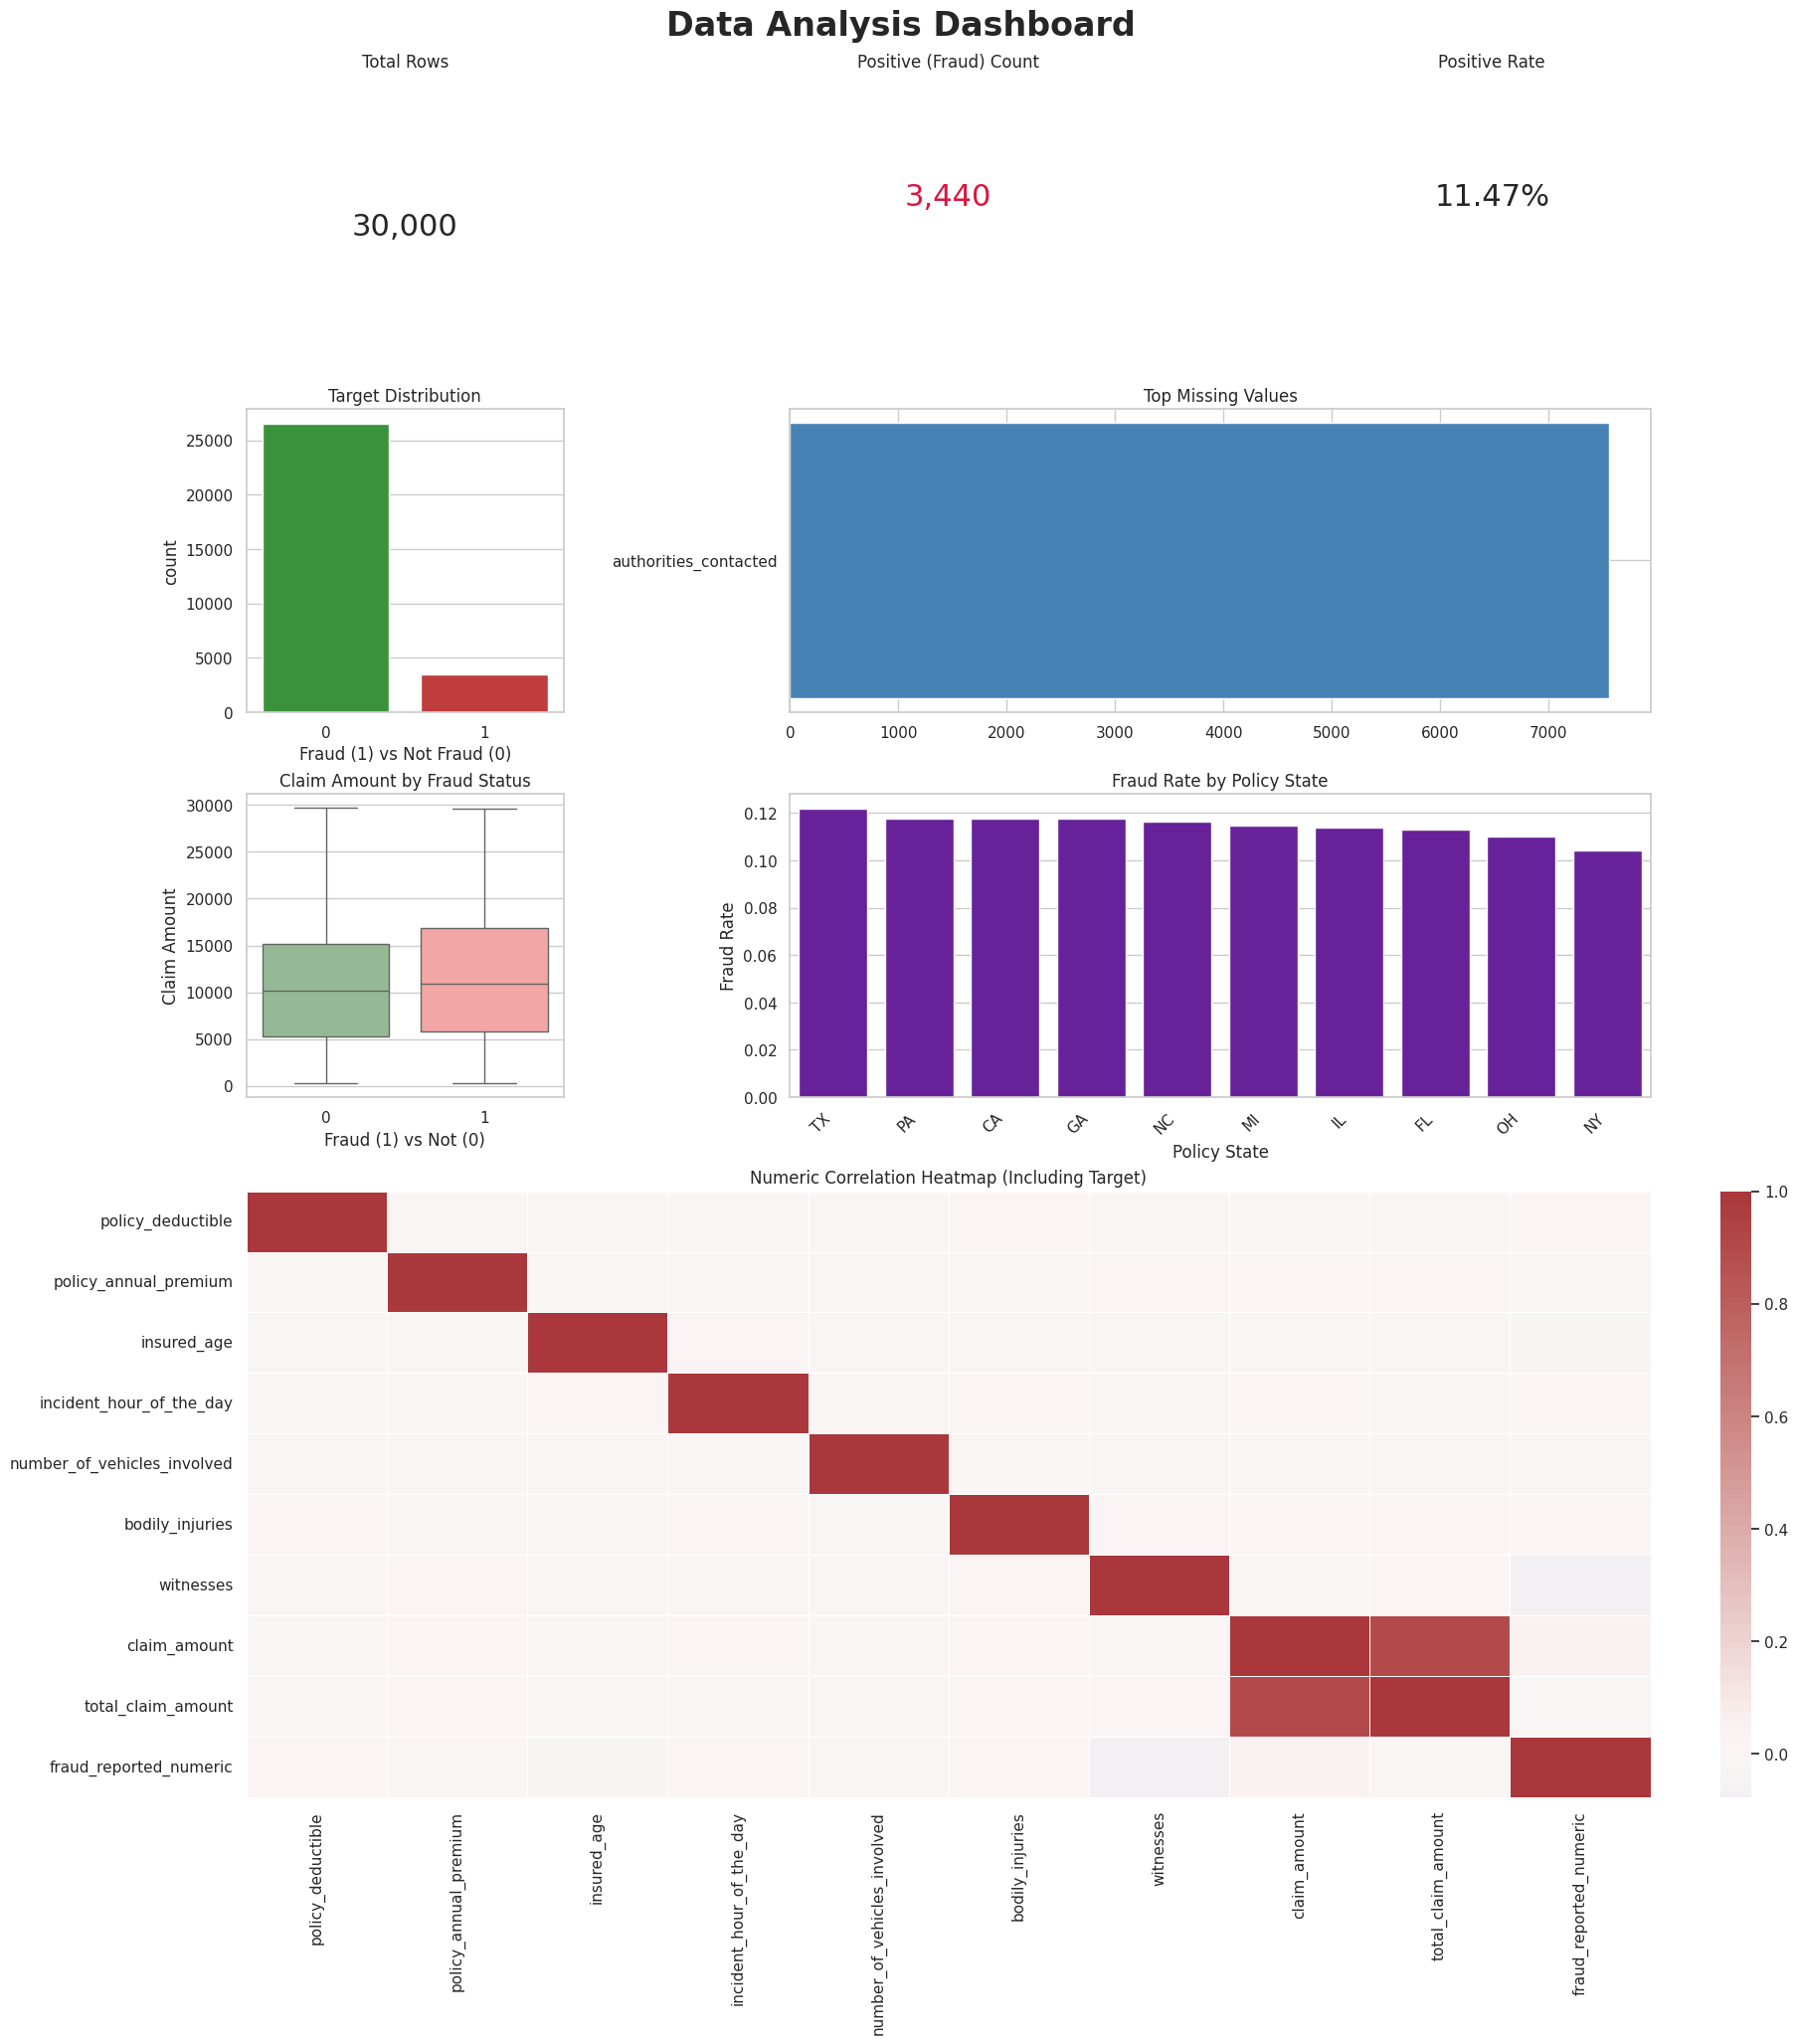

In [572]:
import seaborn as sns
import math
import matplotlib.pyplot as plt

FIG_DPI = 100
plt.rcParams['figure.dpi'] = FIG_DPI
sns.set(style="whitegrid")

# Create a single figure dashboard

fig = plt.figure(figsize=(18, 20), constrained_layout=True)
gs = fig.add_gridspec(5, 3)  # 5 rows, 3 columns

fig.suptitle(
    'Data Analysis Dashboard',
    fontsize=24,
    weight='bold',
    y=1.02
)

# Panel 1: Summary cards (Row 0)
ax_summary_rows = fig.add_subplot(gs[0, 0])
ax_summary_pos = fig.add_subplot(gs[0, 1])
ax_summary_rate = fig.add_subplot(gs[0, 2])

total = len(df)
n_pos = int(y_raw.sum())
pos_rate = n_pos / total if total > 0 else 0

# Total rows
ax_summary_rows.text(0.5, 0.5, f"{total:,}", ha='center', va='center', fontsize=22)
ax_summary_rows.set_title("Total Rows")
ax_summary_rows.axis('off')

# Fraud count
ax_summary_pos.text(0.5, 0.6, f"{n_pos:,}", ha='center', va='center', fontsize=22, color='crimson')
ax_summary_pos.set_title("Positive (Fraud) Count")
ax_summary_pos.axis('off')

# Fraud rate
ax_summary_rate.text(0.5, 0.6, f"{pos_rate*100:.2f}%", ha='center', va='center', fontsize=22)
ax_summary_rate.set_title("Positive Rate")
ax_summary_rate.axis('off')

# Panel 2: Target distribution + missing values (Row 1)
ax_target_dist = fig.add_subplot(gs[1, 0])
sns.countplot(x=y_raw, data=df, palette=['#2ca02c', '#d62728'], ax=ax_target_dist)
ax_target_dist.set_title("Target Distribution")
ax_target_dist.set_xlabel("Fraud (1) vs Not Fraud (0)")

ax_missing = fig.add_subplot(gs[1, 1:])
miss = df.isnull().sum().sort_values(ascending=False).head(10)

if miss.sum() > 0:
    miss = miss[miss > 0]
    ax_missing.barh(miss.index[::-1], miss.values[::-1], color='steelblue')
    ax_missing.set_title("Top Missing Values")
else:
    ax_missing.text(0.5, 0.5, "No Missing Values", ha='center', va='center', fontsize=16)
    ax_missing.axis('off')

# Panel 3: Numeric distribution by target (Row 2, col 0)
ax_numeric_dist = fig.add_subplot(gs[2, 0])
sns.boxplot(
    x=y_raw,
    y=df['claim_amount'],
    palette=['#8fbf8f', '#ff9999'],
    ax=ax_numeric_dist
)
ax_numeric_dist.set_title("Claim Amount by Fraud Status")
ax_numeric_dist.set_xlabel("Fraud (1) vs Not (0)")
ax_numeric_dist.set_ylabel("Claim Amount")

# Panel 4: Fraud rate by policy_state (Row 2, col 1–2)
ax_policy_state_fraud = fig.add_subplot(gs[2, 1:])

if 'policy_state' in df.columns:
    policy_state_ag = (
        df.groupby('policy_state')['fraud_reported']
        .apply(lambda x: x.map(map_to_binary).mean())
        .sort_values(ascending=False)
    )

    sns.barplot(
        x=policy_state_ag.index,
        y=policy_state_ag.values,
        ax=ax_policy_state_fraud,
        color='#6a0dad'  # 🔥 single consistent purple
    )

    ax_policy_state_fraud.set_title("Fraud Rate by Policy State")
    ax_policy_state_fraud.set_xlabel("Policy State")
    ax_policy_state_fraud.set_ylabel("Fraud Rate")
    ax_policy_state_fraud.set_xticklabels(
        ax_policy_state_fraud.get_xticklabels(),
        rotation=45,
        ha='right'
    )
else:
    ax_policy_state_fraud.text(
        0.5, 0.5,
        "Policy State Data N/A",
        ha='center',
        va='center',
        fontsize=16
    )
    ax_policy_state_fraud.axis('off')

# Panel 5: Correlation heatmap (Rows 3–4)
ax_corr_heatmap = fig.add_subplot(gs[3:, :])

numeric_for_corr = [
    c for c in df.select_dtypes(include=['number']).columns
    if df[c].nunique() > 1 and c != target_col
]

if not numeric_for_corr:
    ax_corr_heatmap.text(
        0.5, 0.5,
        "No numeric columns for correlation heatmap.",
        ha='center',
        va='center',
        fontsize=16
    )
    ax_corr_heatmap.axis('off')
else:
    df_temp_corr = df.copy()
    df_temp_corr[target_col + '_numeric'] = df_temp_corr[target_col].map(map_to_binary)
    numeric_for_corr.append(target_col + '_numeric')

    corr = df_temp_corr[numeric_for_corr].corr()

    sns.heatmap(
        corr,
        cmap='vlag',
        center=0,
        annot=False,
        linewidths=0.5,
        ax=ax_corr_heatmap
    )

    ax_corr_heatmap.set_title("Numeric Correlation Heatmap (Including Target)")
    ax_corr_heatmap.tick_params(axis='x', rotation=90)
    ax_corr_heatmap.tick_params(axis='y', rotation=0)

plt.show()

In [573]:
# Feature engineering (interactions, ratios, aggregates, flags, text features)
def add_feature_engineering(df_in):
    df_fe = df_in.copy()
    def exists(c): return c in df_fe.columns

    # interactions
    interactions = [
        ('insured_age','policy_deductible'),
        ('number_of_vehicles_involved','claim_amount'),
        ('claim_amount','policy_annual_premium'),
    ]
    for a,b in interactions:
        if exists(a) and exists(b):
            newcol = f"{a}_x_{b}"
            df_fe[newcol] = pd.to_numeric(df_fe[a], errors='coerce') * pd.to_numeric(df_fe[b], errors='coerce')
            df_fe[newcol] = df_fe[newcol].fillna(0)

    # ratios
    if exists('claim_amount') and exists('policy_annual_premium'):
        denom = pd.to_numeric(df_fe['policy_annual_premium'], errors='coerce').replace(0, np.nan)
        df_fe['claim_over_premium'] = pd.to_numeric(df_fe['claim_amount'], errors='coerce') / denom
        df_fe['claim_over_premium'] = df_fe['claim_over_premium'].fillna(0)

    # aggregates by policy_state
    if exists('policy_state'):
        df_fe['policy_state_count'] = df_fe.groupby('policy_state')['policy_state'].transform('count')
        if exists('claim_amount'):
            df_fe['policy_state_mean_claim'] = df_fe.groupby('policy_state')['claim_amount'].transform('mean').fillna(0)
        else:
            df_fe['policy_state_mean_claim'] = 0

    # time-based
    if exists('incident_hour_of_the_day'):
        df_fe['incident_hour_of_the_day'] = pd.to_numeric(df_fe['incident_hour_of_the_day'], errors='coerce').fillna(-1).astype(int)
        df_fe['incident_is_night'] = df_fe['incident_hour_of_the_day'].apply(lambda x: 1 if (x>=0 and (x<6 or x>=20)) else 0)
    if exists('incident_date'):
        try:
            dt = pd.to_datetime(df_fe['incident_date'], errors='coerce')
            df_fe['incident_month'] = dt.dt.month.fillna(0).astype(int)
            df_fe['incident_weekday'] = dt.dt.weekday.fillna(0).astype(int)
        except Exception:
            pass

    # flags
    if exists('witnesses'):
        df_fe['any_witness'] = pd.to_numeric(df_fe['witnesses'], errors='coerce').fillna(0).apply(lambda x: 1 if x>0 else 0)
    if exists('police_report_available'):
        df_fe['police_report_flag'] = df_fe['police_report_available'].astype(str).str.strip().str.upper().map(lambda s: 1 if s in ('Y','YES','TRUE','1') else 0)
    if exists('authorities_contacted'):
        df_fe['authorities_flag'] = df_fe['authorities_contacted'].astype(str).str.strip().str.upper().map(lambda s: 1 if s in ('Y','YES','TRUE','1') else 0)

    # text features
    text_columns = [c for c in df_fe.columns if 'desc' in c.lower() or 'description' in c.lower() or 'narr' in c.lower() or 'detail' in c.lower()]
    if text_columns:
        tc = text_columns[0]
        df_fe['text_len'] = df_fe[tc].astype(str).fillna('').apply(len)
        keywords = ['fraud','arson','stolen','collision','damage','fake','scam']
        for kw in keywords:
            df_fe[f'kw_{kw}'] = df_fe[tc].astype(str).str.lower().str.contains(kw, na=False).astype(int)

    # derived flags
    if exists('claim_amount') and exists('policy_annual_premium'):
        df_fe['large_claim_flag'] = (pd.to_numeric(df_fe['claim_amount'], errors='coerce') > pd.to_numeric(df_fe['policy_annual_premium'], errors='coerce')*2).astype(int).fillna(0)

    return df_fe

df_fe = add_feature_engineering(df)
print("Feature-engineered shape:", df_fe.shape)

Feature-engineered shape: (30000, 37)


In [574]:
# Prepare X, y and drop id-like/high-card columns
X = df_fe.drop(columns=[target_col]).copy()
y = df_fe[target_col].map(map_to_binary)

# Drop id-like and extremely high-card columns
id_like_cols = [c for c in X.columns if ('id' in c.lower()) or (X[c].nunique() > 0.5 * len(X))]
if id_like_cols:
    print("Dropping id-like/high-card columns:", id_like_cols)
    X = X.drop(columns=id_like_cols, errors='ignore')

Dropping id-like/high-card columns: ['policy_id', 'policy_annual_premium', 'incident_date', 'incident_type', 'incident_severity', 'incident_state', 'incident_city', 'incident_hour_of_the_day', 'claim_amount', 'total_claim_amount', 'number_of_vehicles_involved_x_claim_amount', 'claim_amount_x_policy_annual_premium', 'claim_over_premium', 'incident_is_night', 'incident_month', 'incident_weekday']


In [575]:
# Recompute numeric and categorical lists
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category','bool']).columns.tolist()

# limit categorical one-hot encoding to avoid explosion
MAX_CAT_CARD = 40
categorical_ohe = [c for c in categorical_features if X[c].nunique() <= MAX_CAT_CARD]
high_card_cats = [c for c in categorical_features if c not in categorical_ohe]
if high_card_cats:
    print("Dropping high-card categorical columns:", high_card_cats)
    X = X.drop(columns=high_card_cats, errors='ignore')
    categorical_features = categorical_ohe

print("Numeric features count:", len(numeric_features))
print("Categorical features to OHE count:", len(categorical_features))

Numeric features count: 12
Categorical features to OHE count: 8


In [576]:
# Preprocessor (ColumnTransformer)

numeric_transformer = SklearnPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = SklearnPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Corrected sparse to sparse_output
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

# helper: extract feature names from fitted preprocessor
def get_feature_names_from_preprocessor(fitted_preprocessor, num_cols, cat_cols):
    names = []
    # numeric names
    names.extend(num_cols)
    # categorical OHE names
    try:
        cat_pipeline = None
        for name, trans, cols in fitted_preprocessor.transformers_:
            if name == 'cat':
                cat_pipeline = trans
                cat_cols_in_transformer = cols
                break
        if cat_pipeline is not None:
            ohe = cat_pipeline.named_steps['ohe']
            cat_names = ohe.get_feature_names_out(cat_cols_in_transformer)
            names.extend(cat_names.tolist())
    except Exception:
        # fallback: just use original categorical names
        names.extend(cat_cols)
    return names

In [577]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print("Train/test shapes:", X_train.shape, X_test.shape)
print("Train distribution:\n", y_train.value_counts())

# Baseline pipeline (preprocessor + logistic)
baseline_pipe = SklearnPipeline(steps=[
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

print("\nFitting baseline...")
baseline_pipe.fit(X_train, y_train)

Train/test shapes: (24000, 20) (6000, 20)
Train distribution:
 fraud_reported
0    21248
1     2752
Name: count, dtype: int64

Fitting baseline...


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['policy_deductible',
                                                   'insured_age',
                                                   'number_of_vehicles_involved',
                                                   'bodily_injuries',
                                                   'witnesses',
                                                   'insured_age_x_policy_deductible',
                                                   'policy_state_count',
                                                   'policy_state_mean_claim',
                                                   'any_witness',
                                                   'police...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['policy_state',
                                                   'insured_sex',
                                                   'insured_education_level',
                                                   'insured_occupation',
                                                   'insured_hobbies',
                                                   'collision_type',
                                                   'authorities_contacted',
                                                   'police_report_available'])])),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))])


Baseline (no balancing)
Accuracy: 0.8853333333333333
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5312
           1       0.00      0.00      0.00       688

    accuracy                           0.89      6000
   macro avg       0.44      0.50      0.47      6000
weighted avg       0.78      0.89      0.83      6000

ROC AUC: 0.6392259627171476


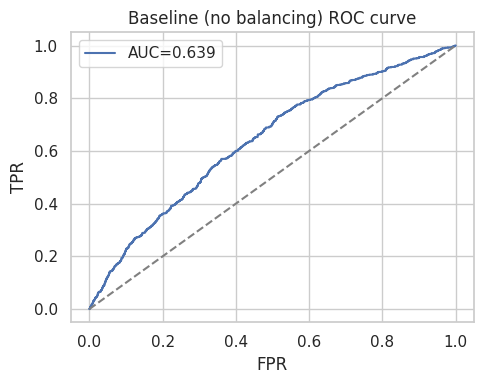

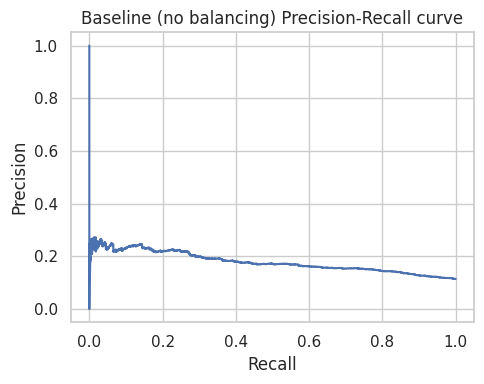

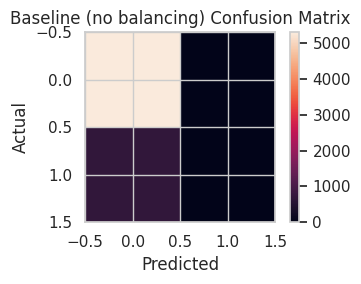

In [578]:
# Evaluate baseline
def eval_and_print(pipe, X_test_local, y_test_local, name="model"):
    y_pred = pipe.predict(X_test_local)
    proba = pipe.predict_proba(X_test_local)[:,1] if hasattr(pipe, "predict_proba") else None
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test_local, y_pred))
    print(classification_report(y_test_local, y_pred, zero_division=0))
    if proba is not None:
        print("ROC AUC:", roc_auc_score(y_test_local, proba))

        # ROC
        fpr, tpr, _ = roc_curve(y_test_local, proba)
        auc = roc_auc_score(y_test_local, proba)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
        plt.plot([0,1],[0,1],"--", color="gray")
        plt.title(f"{name} ROC curve")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout(); plt.show()

        # PR
        prec, rec, _ = precision_recall_curve(y_test_local, proba)
        plt.figure(figsize=(5,4))
        plt.plot(rec, prec)
        plt.title(f"{name} Precision-Recall curve")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.tight_layout(); plt.show()

    cm = confusion_matrix(y_test_local, y_pred)
    plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.colorbar(); plt.tight_layout(); plt.show()

eval_and_print(baseline_pipe, X_test, y_test, "Baseline (no balancing)")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
GridSearch best params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'} Best CV ROC AUC: 0.6397663172463258

SMOTE+Logistic (best C=0.01)
Accuracy: 0.6063333333333333
              precision    recall  f1-score   support

           0       0.92      0.61      0.73      5312
           1       0.16      0.57      0.25       688

    accuracy                           0.61      6000
   macro avg       0.54      0.59      0.49      6000
weighted avg       0.83      0.61      0.68      6000

ROC AUC: 0.6406696006409358


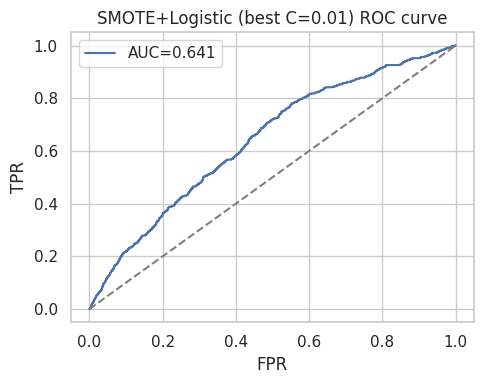

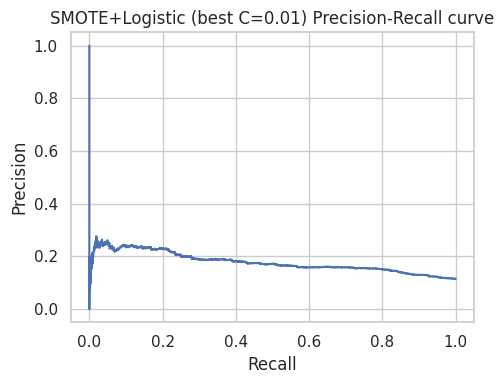

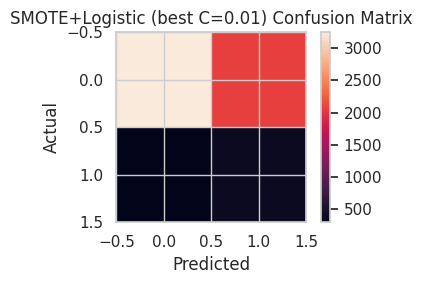

In [549]:
# SMOTE + Logistic in imblearn pipeline + GridSearch
sampler = SMOTE(random_state=RANDOM_STATE)  # Removed n_jobs=-1
imb_pipeline = ImbPipeline(steps=[
    ('pre', preprocessor),
    ('smote', sampler),
    ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['liblinear']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(imb_pipeline, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)
print("GridSearch best params:", grid.best_params_, "Best CV ROC AUC:", grid.best_score_)

best_pipeline = grid.best_estimator_

# Evaluate best_pipeline on holdout
eval_and_print(best_pipeline, X_test, y_test, name=f"SMOTE+Logistic (best C={grid.best_params_['clf__C']})")



Calibration: creating a small validation split from training data
Fitting CalibratedClassifierCV (cv='prefit') on validation set...

Calibrated SMOTE+Logistic metrics:
Accuracy: 0.8853333333333333
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5312
           1       0.00      0.00      0.00       688

    accuracy                           0.89      6000
   macro avg       0.44      0.50      0.47      6000
weighted avg       0.78      0.89      0.83      6000

ROC AUC: 0.6366497968618661


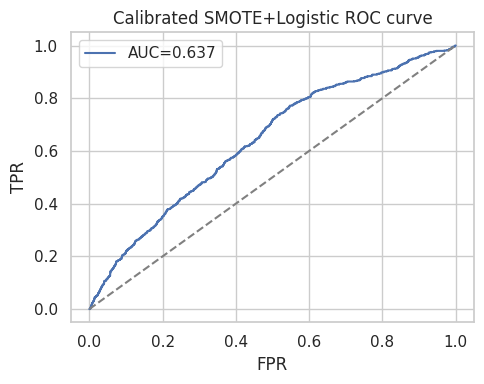

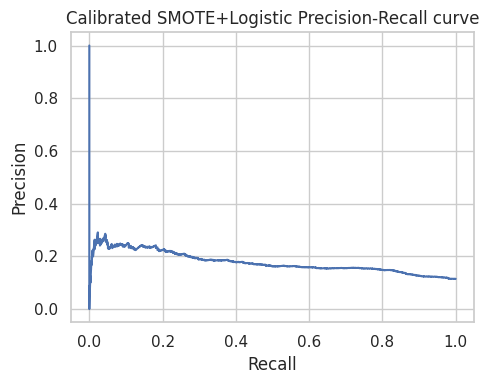

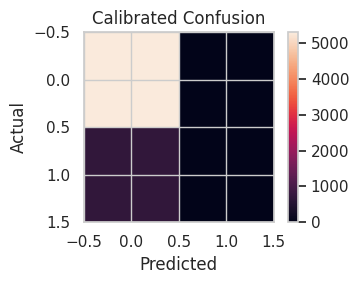

In [550]:
# Calibration using a validation split

print("\nCalibration: creating a small validation split from training data")
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=RANDOM_STATE, stratify=y_train)
# Refit best_pipeline on X_train2 (so calibration then uses X_val)
best_pipeline.fit(X_train2, y_train2)
print("Fitting CalibratedClassifierCV (cv='prefit') on validation set...")
try:
    calibrated = CalibratedClassifierCV(estimator=best_pipeline, method='sigmoid', cv='prefit') # Changed base_estimator to estimator
    calibrated.fit(X_val, y_val)  # calibrate on the validation set
    # evaluate calibrated
    y_pred_cal = calibrated.predict(X_test)
    y_score_cal = calibrated.predict_proba(X_test)[:,1]
    print("\nCalibrated SMOTE+Logistic metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred_cal))
    print(classification_report(y_test, y_pred_cal, zero_division=0))
    print("ROC AUC:", roc_auc_score(y_test, y_score_cal))

    # ROC for Calibrated SMOTE+Logistic
    fpr, tpr, _ = roc_curve(y_test, y_score_cal)
    auc = roc_auc_score(y_test, y_score_cal)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.title("Calibrated SMOTE+Logistic ROC curve")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout(); plt.show()
    # PR for Calibrated SMOTE+Logistic
    prec, rec, _ = precision_recall_curve(y_test, y_score_cal)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec)
    plt.title("Calibrated SMOTE+Logistic Precision-Recall curve")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.tight_layout(); plt.show()

    cm_calibrated = confusion_matrix(y_test, y_pred_cal)
    plt.figure(figsize=(4,3))
    plt.imshow(cm_calibrated, interpolation="nearest")
    plt.title("Calibrated Confusion")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.colorbar(); plt.tight_layout(); plt.show()
except Exception as e:
    print("Calibration step failed or skipped:", e)
    print("Consider calibrating using CalibratedClassifierCV with cv=3 on a larger validation set if needed.")


Preparing preprocessed matrices for L1 selection...
Preprocessed feature count: 53
Fitting L1 logistic for feature selection...
Selected feature count: 27
Selected features (first 40): ['insured_age', 'policy_state_mean_claim', 'any_witness', 'policy_state_CA', 'policy_state_MI', 'policy_state_NY', 'policy_state_OH', 'policy_state_TX', 'insured_sex_FEMALE', 'insured_education_level_PhD', 'insured_occupation_Clerk', 'insured_occupation_Doctor', 'insured_occupation_Engineer', 'insured_occupation_Lawyer', 'insured_occupation_Sales', 'insured_occupation_Teacher', 'insured_occupation_Technician', 'insured_hobbies_hiking', 'insured_hobbies_movies', 'insured_hobbies_paintball', 'insured_hobbies_reading', 'insured_hobbies_yachting', 'collision_type_Front', 'authorities_contacted_Ambulance', 'authorities_contacted_Fire', 'authorities_contacted_Police', 'police_report_available_Yes']

L1-selected model metrics:
Accuracy: 0.6255
              precision    recall  f1-score   support

           0

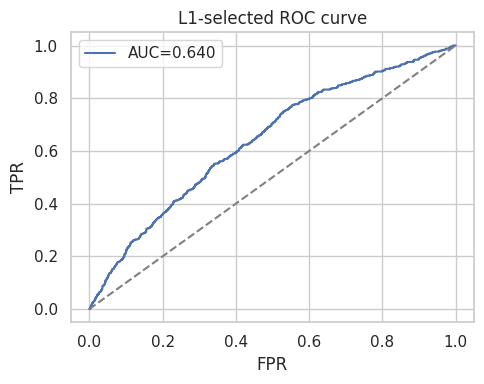

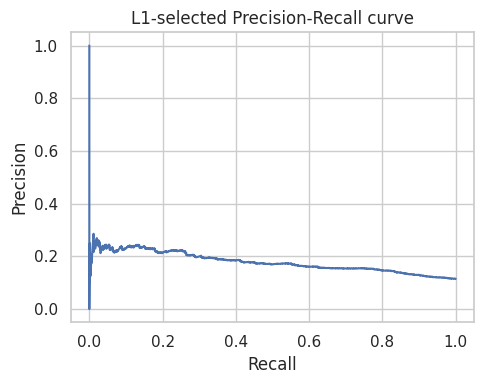

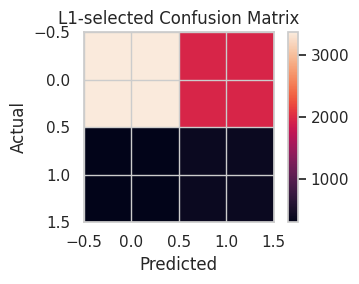

In [551]:
# L1 feature selection on preprocessed features
print("\nPreparing preprocessed matrices for L1 selection...")

# Use the preprocessor that is now fitted inside baseline_pipe
fitted_pre = baseline_pipe.named_steps['pre']

# Transform train and test with fitted preprocessor
X_train_trans = fitted_pre.transform(X_train)
X_test_trans = fitted_pre.transform(X_test)

# Extract feature names
feature_names = get_feature_names_from_preprocessor(fitted_pre, numeric_features, categorical_features)
print("Preprocessed feature count:", len(feature_names))

print("Fitting L1 logistic for feature selection...")
l1_log = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, class_weight='balanced', max_iter=2000, random_state=RANDOM_STATE)
l1_log.fit(X_train_trans, y_train)
selector = SelectFromModel(l1_log, prefit=True, threshold='median')
mask = selector.get_support()
selected_feature_names = [name for name, m in zip(feature_names, mask) if m]
print("Selected feature count:", len(selected_feature_names))
print("Selected features (first 40):", selected_feature_names[:40])

# Train logistic on selected features
X_train_sel = selector.transform(X_train_trans)
X_test_sel = selector.transform(X_test_trans)
clf_sel = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear', random_state=RANDOM_STATE)
clf_sel.fit(X_train_sel, y_train)
y_pred_sel = clf_sel.predict(X_test_sel)
y_score_sel = clf_sel.predict_proba(X_test_sel)[:,1]
print("\nL1-selected model metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_sel))
print(classification_report(y_test, y_pred_sel, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_score_sel))

# ROC for L1-selected model
fpr, tpr, _ = roc_curve(y_test, y_score_sel)
auc = roc_auc_score(y_test, y_score_sel)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.title("L1-selected ROC curve")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout(); plt.show()

# PR for L1-selected model
prec, rec, _ = precision_recall_curve(y_test, y_score_sel)
plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.title("L1-selected Precision-Recall curve")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.tight_layout(); plt.show()

cm_l1 = confusion_matrix(y_test, y_pred_sel)
plt.figure(figsize=(4,3))
plt.imshow(cm_l1, interpolation="nearest")
plt.title("L1-selected Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.colorbar(); plt.tight_layout(); plt.show()


Threshold tuning (maximize F1) using best_pipeline predictions on test set
Best threshold (max F1): 0.44284753779021774 Best F1: 0.258097424126209
Classification at tuned threshold:
              precision    recall  f1-score   support

           0       0.93      0.49      0.64      5312
           1       0.16      0.74      0.26       688

    accuracy                           0.52      6000
   macro avg       0.55      0.61      0.45      6000
weighted avg       0.85      0.52      0.60      6000



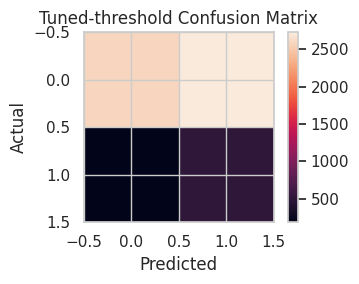

In [552]:
# Threshold tuning on best_pipeline probabilities (maximize F1)
print("\nThreshold tuning (maximize F1) using best_pipeline predictions on test set")
y_scores_best = best_pipeline.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_best)
f1s = 2 * precisions * recalls / (precisions + recalls + 1e-12)
best_idx = np.nanargmax(f1s)
best_threshold = thresholds[best_idx] if len(thresholds) > 0 else 0.5
print("Best threshold (max F1):", best_threshold, "Best F1:", f1s[best_idx])
y_pred_tuned = (y_scores_best >= best_threshold).astype(int)
print("Classification at tuned threshold:")
print(classification_report(y_test, y_pred_tuned, zero_division=0))

cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(4,3))
plt.imshow(cm_tuned, interpolation="nearest")
plt.title("Tuned-threshold Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.colorbar(); plt.tight_layout(); plt.show()

In [553]:
# Cross-validated ROC AUC quick check (3-fold)
print("\nCross-validated ROC AUC (3-fold) for SMOTE+Logistic with best params")
cv_pipe = ImbPipeline(steps=[
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', LogisticRegression(C=grid.best_params_['clf__C'], solver='liblinear', class_weight='balanced', max_iter=2000))
])
cv_scores = cross_val_score(cv_pipe, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE), scoring='roc_auc', n_jobs=-1)
print("CV ROC AUC (3-fold):", np.round(cv_scores,4), "Mean:", np.round(cv_scores.mean(),4))


Cross-validated ROC AUC (3-fold) for SMOTE+Logistic with best params
CV ROC AUC (3-fold): [0.6502 0.6406 0.6344] Mean: 0.6417


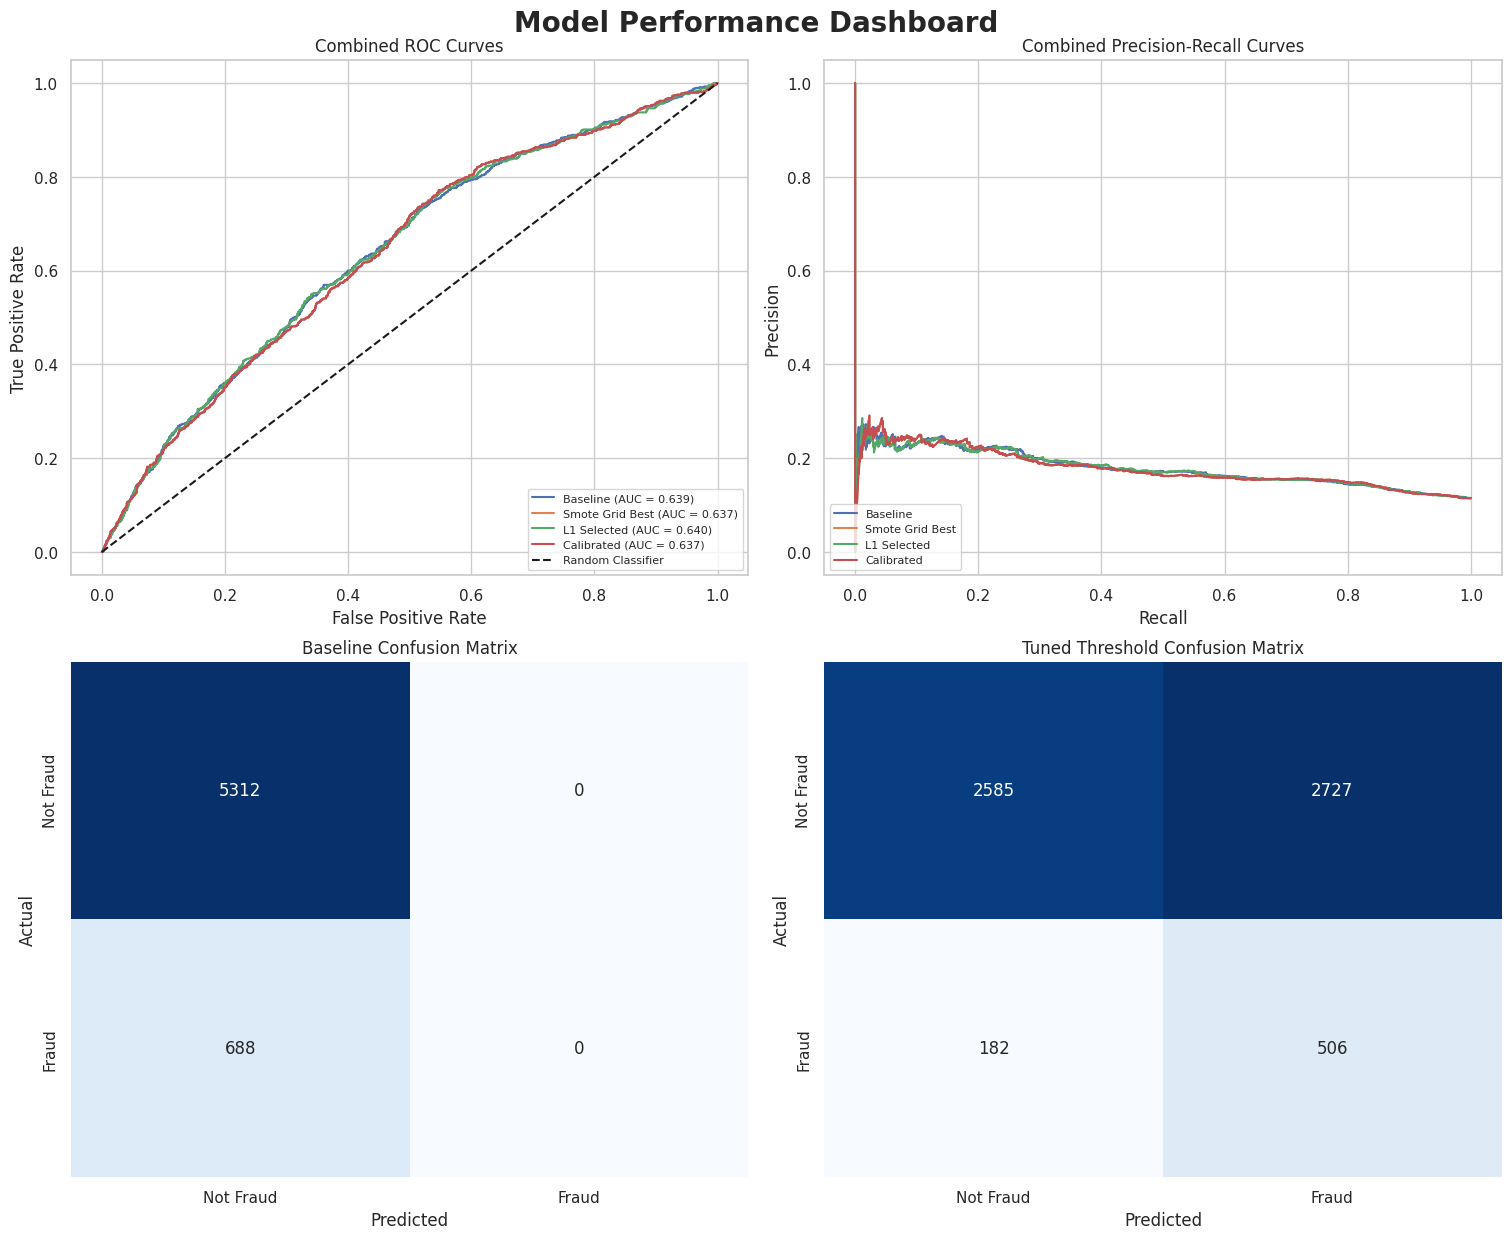

In [554]:
# Model performanace dashbaord

# Prepare data for dashboard
model_names_for_roc_pr = ['baseline', 'smote_grid_best', 'l1_selected', 'calibrated']

# Create a figure to host multiple subplots for the dashboard

# Now a 2x2 grid as the table is removed
fig = plt.figure(figsize=(15, 12), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

# Card 1: Combined ROC Curves (Top-left)
ax0 = fig.add_subplot(gs[0, 0])
for name in model_names_for_roc_pr:
    if model_data[name]['y_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, model_data[name]['y_proba'])
        auc = roc_auc_score(y_test, model_data[name]['y_proba'])
        ax0.plot(fpr, tpr, label=f'{name.replace("_", " ").title()} (AUC = {auc:.3f})')
ax0.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax0.set_xlabel('False Positive Rate')
ax0.set_ylabel('True Positive Rate')
ax0.set_title('Combined ROC Curves')
ax0.legend(loc='lower right', fontsize=8)
ax0.grid(True)

# Card 2: Combined Precision-Recall Curves (Top-right)
ax1 = fig.add_subplot(gs[0, 1])
for name in model_names_for_roc_pr:
    if model_data[name]['y_proba'] is not None:
        precisions, recalls, _ = precision_recall_curve(y_test, model_data[name]['y_proba'])
        ax1.plot(recalls, precisions, label=f'{name.replace("_", " ").title()}')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Combined Precision-Recall Curves')
ax1.legend(loc='lower left', fontsize=8)
ax1.grid(True)

# Card 3: Confusion Matrix: Baseline (Bottom-left)
ax2 = fig.add_subplot(gs[1, 0])
cm_base = model_data['baseline']['cm']
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
ax2.set_title('Baseline Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# Card 4: Confusion Matrix: Tuned Threshold (Bottom-right)
ax3 = fig.add_subplot(gs[1, 1])
cm_tuned = model_data['tuned_threshold']['cm']
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax3,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
ax3.set_title('Tuned Threshold Confusion Matrix')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

fig.suptitle('Model Performance Dashboard', fontsize=20, weight='bold', y=1.02)
plt.show()

In [555]:
# Metrics summary & saving outputs
def collect_metrics_from_pipe(pipe, X_test_local, y_test_local):
    y_pred = pipe.predict(X_test_local)
    proba = pipe.predict_proba(X_test_local)[:,1] if hasattr(pipe, "predict_proba") else None
    return {
        'accuracy': accuracy_score(y_test_local, y_pred),
        'precision': precision_score(y_test_local, y_pred, zero_division=0),
        'recall': recall_score(y_test_local, y_pred, zero_division=0),
        'f1': f1_score(y_test_local, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test_local, proba) if proba is not None else None
    }

metrics = {}
metrics['baseline'] = collect_metrics_from_pipe(baseline_pipe, X_test, y_test)
metrics['smote_grid_best'] = collect_metrics_from_pipe(best_pipeline, X_test, y_test)
metrics['l1_selected'] = {
    'accuracy': accuracy_score(y_test, y_pred_sel),
    'precision': precision_score(y_test, y_pred_sel, zero_division=0),
    'recall': recall_score(y_test, y_pred_sel, zero_division=0),
    'f1': f1_score(y_test, y_pred_sel, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_score_sel)
}
metrics['tuned_threshold'] = {
    'accuracy': accuracy_score(y_test, y_pred_tuned),
    'precision': precision_score(y_test, y_pred_tuned, zero_division=0),
    'recall': recall_score(y_test, y_pred_tuned, zero_division=0),
    'f1': f1_score(y_test, y_pred_tuned, zero_division=0),
    'roc_auc': None
}

metrics_df = pd.DataFrame(metrics).T
print("\nMetrics summary (rounded):")
print(metrics_df.round(4))
metrics_df.to_csv("metrics_summary.csv", index=True)
pd.DataFrame({'selected_feature': selected_feature_names}).to_csv("selected_features_l1.csv", index=False)
print("Saved metrics_summary.csv and selected_features_l1.csv in working directory")


Metrics summary (rounded):
                 accuracy  precision  recall      f1  roc_auc
baseline           0.8853     0.0000  0.0000  0.0000   0.6392
smote_grid_best    0.6067     0.1604  0.5741  0.2508   0.6366
l1_selected        0.6255     0.1667  0.5669  0.2577   0.6396
tuned_threshold    0.5152     0.1565  0.7355  0.2581      NaN
Saved metrics_summary.csv and selected_features_l1.csv in working directory
